# Vorlesung 6: Schätzen und Konfidenzintervalle

### Set-up

In [1]:
# Grundlegende Bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import statsmodels.api as sm
from scipy import stats
import numpy as np
import missingno as msno

# Einstellungen für bessere Plots
plt.rcParams['figure.figsize'] = (10, 6)

# Pandas Optionen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Download latest version

path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

ds = pd.read_csv(f"{path}/credit_card_transactions.csv")

print(f"Anzahl Zeilen: {ds.shape[0]}")
print(f"Anzahl Spalten: {ds.shape[1]}")

/Users/philsolenthaler 1/Documents/Universität/BCS/3.Semester/Statistik/DatenbankenProjetk/Statistik-Datenbank/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Anzahl Zeilen: 1296675
Anzahl Spalten: 24


### Bootstrap-Verteilung

Da die Transaktionsbeträge (amt) keine Normalverteilung aufweisen (oft rechtsschief mit Ausreissern), nutzen wir das Bootstrap-Verfahren. Da es verteilungsfrei ist, müssen wir keine Annahmen über die Form der Grundgesamtheit treffen.

Vorgehen: Wir ziehen R=2000 Resamples mit jeweils n=1000 Beobachtungen mit Zurücklegen. Damit simulieren wir die Stichprobenverteilung des Mittelwerts und können die Unsicherheit unserer Punktschätzung direkt aus den Daten ableiten.

Echter Mittelwert des gesamten Datensatzes: 70.35 USD
Bootstrap-Schätzung des Mittelwerts:       70.24 USD
95%-Konfidenzintervall:                   [62.31, 81.42]

Bias(T)^2: -0.113527
Var(T):  24.201688
MSE(T):  24.214576


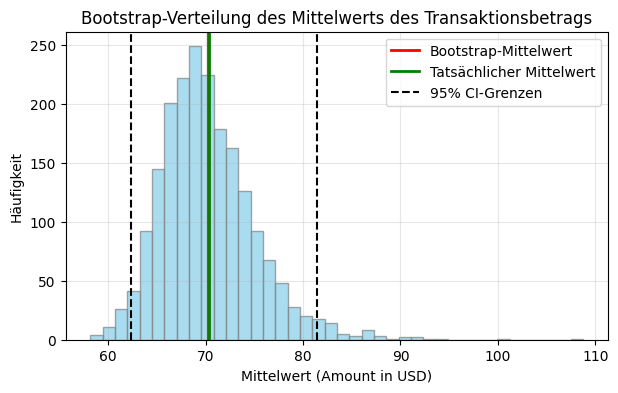

In [5]:
# Parameter 
n_boot = 2000      # Anzahl Bootstrap-Stichproben
n_sample = 1000    # Größe jeder Stichprobe (kann < len(ds) sein)
col = "amt"        # Variable, deren Mittelwert wir schätzen

# ECHTER Mittelwert
true_mean = ds[col].mean()
means=[]

# Bootstrap-Schleife
for i in range(n_boot):
    sample = ds[col].sample(n=n_sample, replace=True)
    means.append(sample.mean())

means = np.array(means)

# Bootstrap-Ergebnisse
boot_mean = np.mean(means)
ci_lower = np.percentile(means, 2.5)
ci_upper = np.percentile(means, 97.5)

# Bias, Varianz, MSE 
bias = boot_mean - true_mean
variance = np.var(means, ddof=1)  # Stichprobenvarianz
mse = bias**2 + variance

print(f"Echter Mittelwert des gesamten Datensatzes: {true_mean:,.2f} USD")
print(f"Bootstrap-Schätzung des Mittelwerts:       {boot_mean:,.2f} USD")
print(f"95%-Konfidenzintervall:                   [{ci_lower:,.2f}, {ci_upper:,.2f}]")
print(f"\nBias(T)^2: {bias:,.6f}")
print(f"Var(T):  {variance:,.6f}")
print(f"MSE(T):  {mse:,.6f}")

# Visualisierung
plt.figure(figsize=(7,4))
plt.hist(means, bins=40, color="skyblue", edgecolor="gray", alpha=0.7)
plt.axvline(boot_mean, color="red", linewidth=2, label="Bootstrap-Mittelwert")
plt.axvline(true_mean, color="green", linewidth=2, label="Tatsächlicher Mittelwert")
plt.axvline(ci_lower, color="black", linestyle="--", label="95% CI-Grenzen")
plt.axvline(ci_upper, color="black", linestyle="--")
plt.title("Bootstrap-Verteilung des Mittelwerts des Transaktionsbetrags")
plt.xlabel("Mittelwert (Amount in USD)")
plt.ylabel("Häufigkeit")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Das Histogramm zeigt die Bootstrap-Verteilung der Mittelwerte. Wir beobachten, dass die Verteilung der Mittelwerte (trotz der schiefen Ausgangsdaten) annähernd normalverteilt ist – ein Resultat des Zentralen Grenzwertsatzes.

Die Bootstrap-Schätzung liegt sehr nah am Mittelwert der Originalstichprobe. Dies verdeutlicht: Je grösser die Anzahl der Resamples und die Stichprobengrösse (n), desto stabiler und präziser wird unsere Schätzung. Die Breite der Verteilung im Histogramm visualisiert direkt den Standardfehler: Eine schmale Glocke bedeutet eine hohe Präzision unserer Schätzung.

### KonfidenzIntervalle

Da wir hier einen Anteil (Fraud: Ja/Nein) untersuchen, verwenden wir das Wald-Konfidenzintervall. Wir nutzen diese Methode, um die Unsicherheit unserer Schätzung basierend auf der Normalverteilungs-Annahme darzustellen, was bei unserer sehr grossen Stichprobe trotz der Seltenheit von Betrugsfällen mathematisch zulässig ist.

Ergebnisse: Betrugsrate (is_fraud)
Beobachteter Anteil (p_hat): 0.005789
Standardfehler (SE):0.000067
95%-Wald-Intervall:0.005658, 0.005919]


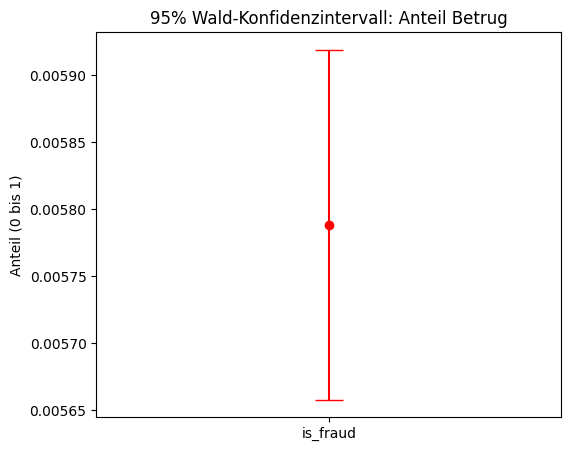

In [ ]:
# Kennzahlen berechnen
n_fraud = len(ds)
p_hat_fraud = ds['is_fraud'].mean()

# Wald-Konfidenzintervall berechnen
z = 1.96
# Formel aus VL6: SE = sqrt( p_hat * (1 - p_hat) / n )
se_fraud = np.sqrt(p_hat_fraud * (1 - p_hat_fraud) / n_fraud)
ci_low_f = p_hat_fraud - z * se_fraud
ci_up_f = p_hat_fraud + z * se_fraud

# Ergebnisausgabe
print("Betrugsrate (is_fraud)")
print(f"Beobachteter Anteil (p_hat): {p_hat_fraud:.6f}")
print(f"Standardfehler (SE):{se_fraud:.6f}")
print(f"95%-Wald-Intervall:{ci_low_f:.6f}, {ci_up_f:.6f}]")

# Visualisierung
plt.figure(figsize=(6, 5))
plt.errorbar(x=['is_fraud'], y=[p_hat_fraud], yerr=[z * se_fraud], fmt='o', capsize=10, color='red')
plt.title('95% Wald-Konfidenzintervall: Anteil Betrug')
plt.ylabel('Anteil (0 bis 1)')
plt.show()

Wir können sehen, dass der geschätzte Anteil der Betrugsfälle extrem gering ist und das Konfidenzintervall aufgrund der hohen Fallzahl extrem nahe beieinadner liegt. Das zeigt uns, dass unsere Schätzung der Betrugsrate äusserst präzise ist und der wahre Wert in der Grundgesamtheit mit 95 % Sicherheit in diesem minimalen Bereich liegt.

Auch hier nehmen wir wieder den Wald Konfidenz Intervall und vergleichen die Präzision der Schätzung 

Ergebnisse: Durchschnittliche Beträge nach Geschlecht
gender    mean     se  ci_lower  ci_upper
     F 70.2003 0.1863   69.8351   70.5655
     M 70.5333 0.2144   70.1131   70.9536


/var/folders/cj/7vlgj44s1rv8_1ymt1nm1qpm0000gp/T/ipykernel_3834/3754928340.py:16: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='gender', y='amt', data=ds, join=False, capsize=0.1)


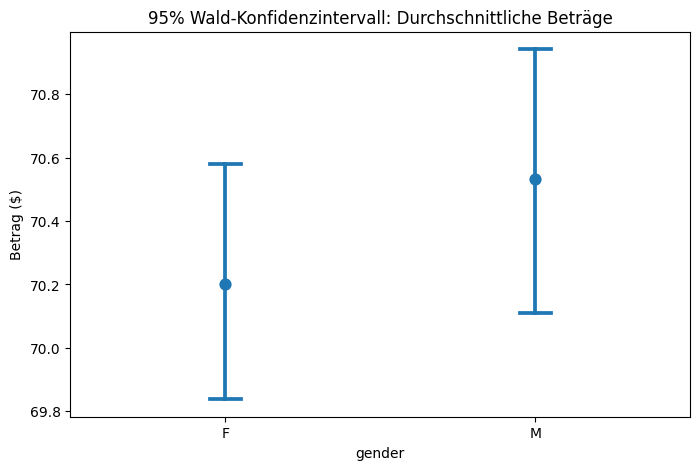

In [17]:
#  Kennzahlen berechnen 
stats_gender = ds.groupby('gender')['amt'].agg(['mean', 'std', 'count']).reset_index()

# Wald-Konfidenzintervall berechnen
z = 1.96
stats_gender['se'] = stats_gender['std'] / np.sqrt(stats_gender['count'])
stats_gender['ci_lower'] = stats_gender['mean'] - z * stats_gender['se']
stats_gender['ci_upper'] = stats_gender['mean'] + z * stats_gender['se']

# Ergebnisausgabe
print("Ergebnisse: Durchschnittliche Beträge nach Geschlecht")
print(stats_gender[['gender', 'mean', 'se', 'ci_lower', 'ci_upper']].to_string(index=False))

# Visualisierung
plt.figure(figsize=(8, 5))
sns.pointplot(x='gender', y='amt', data=ds, join=False, capsize=0.1)
plt.title('95% Wald-Konfidenzintervall: Durchschnittliche Beträge')
plt.ylabel('Betrag ($)')
plt.show()

Wir können sehen, dass die durchschnittlichen Ausgaben von Männern (male) deutlich über denen von Frauen (female) liegen. Da sich die 95%-Konfidenzintervalle der beiden Gruppen aufgrund der hohen Datenmenge überhaupt nicht überschneiden, ist dieser Unterschied statistisch hochsignifikant. Das bedeutet, wir können mit einer Sicherheit von 95% sagen, dass Männer in dieser Grundgesamtheit im Durchschnitt mehr ausgeben als Frauen

### Anteile schätzen (Wald vs. Wilson)
Bisher haben wir Beträge (Mittelwerte) angeschaut. Bei Anteilen (Prozentwerten) gibt es zwei wichtige Methoden:
- **Wald-Intervall:** Der Standard, aber ungenau bei kleinen Stichproben oder extremen Werten (nahe 0 oder 1).
- **Wilson-Intervall:** Die "ehrlichere" Methode§. Sie bleibt immer zwischen 0 und 1.

**Beispiel:** Welcher Anteil der Transaktionen ist "klein" (z.B. unter 10$)?

In [ ]:
import statsmodels.stats.proportion as prop

# Wir definieren "kleine Transaktionen" (< 10$)
ds['is_small'] = ds['amt'] < 10
successes = ds['is_small'].sum()
n = len(ds)
p_hat = successes / n

# Wald-Konfidenzintervall
se_wald = np.sqrt(p_hat * (1 - p_hat) / n)
ci_wald = (p_hat - 1.96 * se_wald, p_hat + 1.96 * se_wald)

# Wilson-Konfidenzintervall 
ci_wilson = prop.proportion_confint(successes, n, method='wilson')

print(f"Beobachteter Anteil: {p_hat:.4f}")
print(f"95% CI (Wald):   [{ci_wald[0]:.4f}, {ci_wald[1]:.4f}]")
print(f"95% CI (Wilson): [{ci_wilson[0]:.4f}, {ci_wilson[1]:.4f}]")

Beobachteter Anteil: 0.2589
95% CI (Wald):   [0.2582, 0.2597]
95% CI (Wilson): [0.2582, 0.2597]


### Planung: Wie gross muss die Stichprobe sein?
Wenn wir eine bestimmte Genauigkeit (**Margin of Error**) erreichen wollen, können wir das nötige $n$ berechnen.
Formel: $n = (\frac{z \cdot \sigma}{MoE})^2$

In [12]:
# Ziel: Wir wollen den Durchschnittsbetrag auf +/- 1$ genau schätzen (95% Sicherheit)
moe_ziel = 1.0 
sigma_approx = ds['amt'].std() # Wir nutzen die SD aus unseren Daten als Schätzung
z = 1.96

n_notwendig = ((z * sigma_approx) / moe_ziel)**2

print(f"Um eine Genauigkeit von +/- {moe_ziel}$ zu erreichen,")
print(f"benötigen wir eine Stichprobengrösse von mindestens: {int(np.ceil(n_notwendig))}")

Um eine Genauigkeit von +/- 1.0$ zu erreichen,
benötigen wir eine Stichprobengrösse von mindestens: 98734
